In [1]:
import argparse
import os
import shutil
import gzip

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch
import torch.nn as nn
from torch.autograd import Variable

from dpp_nets.utils.language import Vocabulary, BeerDataset, custom_collate
from dpp_nets.layers.layers import ChunkTrainer, ChunkTrainerRel

from dpp_nets.utils.language import EvalSet

In [2]:
from dpp_nets.utils.language import Vocabulary

embd_path = '/Users/Max/data/beer_reviews/review+wiki.filtered.200.txt.gz'
word_path = '/Users/Max/data/beer_reviews/reviews.all.train.words.txt.gz'

# Set-up Vocabulary
vocab = Vocabulary()
vocab.loadPretrained(embd_path)
vocab.setStops()
vocab.loadCorpus(word_path)
vocab.updateEmbedding()
vocab.setCuda(False)

In [3]:
# Load saved checkpoint
model = 'allsents1reg0.1reg_mean3.0lr0.001marginal_best_ckp.pth.tar'
model_dir = '/Users/Max/checkpoints/beer_reviews/marginal/' 
model_path = model_dir + model
model = torch.load(model_path, map_location=lambda storage, loc: storage)
vocab.EmbeddingBag.load_state_dict(model['embedding'])

In [4]:
EMBD_DIM = 200
KERNEL_DIM = 200
HIDDEN_DIM = 500
ENC_DIM = 200
TARGET_DIM = 3 if model['aspect'] in set(['all', 'short']) else 1

if model['mode'] == 'sents':
    trainer = ChunkTrainer(EMBD_DIM, HIDDEN_DIM, KERNEL_DIM, ENC_DIM, TARGET_DIM)
else:
    trainer = ChunkTrainerRel(EMBD_DIM, HIDDEN_DIM, KERNEL_DIM, ENC_DIM, TARGET_DIM)

trainer.load_state_dict(model['model'])
trainer.activation = nn.Sigmoid()
trainer.reg = model['reg']
trainer.reg_mean = model['reg_mean']

rat_path = '/Users/Max/data/beer_reviews/annotations.json'
evalset = EvalSet(rat_path, vocab)

In [5]:
# Plot a table
print('__________________________Training Table__________________________')
for k, v in model['train_loss'].items():
    epoch, loss, pred_loss, reg_loss = k, v[0], model['train_pred_loss'][k][0], model['train_reg_loss'][k][0]
    print(str.join(" | ", ['Epoch: %d' % (epoch), 'Loss: %.5f' % (loss), 
                              'Pred Loss: %.5f' % (pred_loss), 'Reg Loss: %.5f' % (reg_loss)]))

__________________________Training Table__________________________
Epoch: 0 | Loss: 0.14926 | Pred Loss: 0.03402 | Reg Loss: 0.11524
Epoch: 1 | Loss: 0.03439 | Pred Loss: 0.02443 | Reg Loss: 0.00996
Epoch: 2 | Loss: 0.03178 | Pred Loss: 0.02231 | Reg Loss: 0.00948
Epoch: 3 | Loss: 0.03025 | Pred Loss: 0.02090 | Reg Loss: 0.00935
Epoch: 4 | Loss: 0.02886 | Pred Loss: 0.01958 | Reg Loss: 0.00929
Epoch: 5 | Loss: 0.02709 | Pred Loss: 0.01784 | Reg Loss: 0.00926
Epoch: 6 | Loss: 0.02530 | Pred Loss: 0.01607 | Reg Loss: 0.00923
Epoch: 7 | Loss: 0.02433 | Pred Loss: 0.01512 | Reg Loss: 0.00921
Epoch: 8 | Loss: 0.02362 | Pred Loss: 0.01442 | Reg Loss: 0.00919
Epoch: 9 | Loss: 0.02246 | Pred Loss: 0.01327 | Reg Loss: 0.00918
Epoch: 10 | Loss: 0.02182 | Pred Loss: 0.01264 | Reg Loss: 0.00918
Epoch: 11 | Loss: 0.02107 | Pred Loss: 0.01190 | Reg Loss: 0.00917


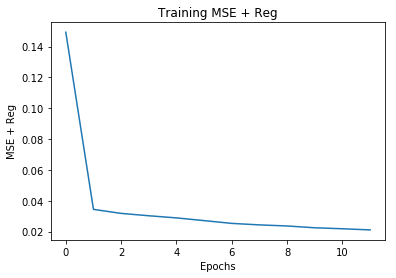

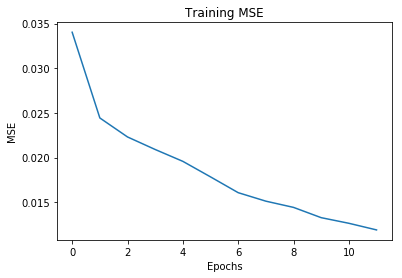

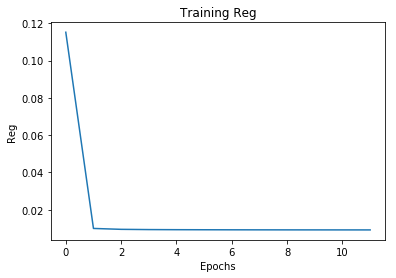

In [6]:
from dpp_nets.helper.plotting import plot_floats

# Training Plots
plot_floats(model['train_loss'], xlabel='Epochs', ylabel='MSE + Reg', title='Training MSE + Reg')
plot_floats(model['train_pred_loss'], xlabel='Epochs', ylabel='MSE', title='Training MSE')
plot_floats(model['train_reg_loss'], xlabel='Epochs', ylabel='Reg', title='Training Reg')

In [7]:
print('_________________________Validation Table_________________________')
for k, v in model['val_loss'].items():
    epoch, loss, pred_loss, reg_loss = k, v[0], model['val_pred_loss'][k][0], model['val_reg_loss'][k][0]
    print(str.join(" | ", ['Epoch: %d' % (epoch), 'Loss: %.5f' % (loss), 
                              'Pred Loss: %.5f' % (pred_loss), 'Reg Loss: %.5f' % (reg_loss)]))

_________________________Validation Table_________________________
Epoch: 0 | Loss: 0.03836 | Pred Loss: 0.02736 | Reg Loss: 0.01100
Epoch: 1 | Loss: 0.03334 | Pred Loss: 0.02308 | Reg Loss: 0.01027
Epoch: 2 | Loss: 0.03233 | Pred Loss: 0.02221 | Reg Loss: 0.01012
Epoch: 3 | Loss: 0.03060 | Pred Loss: 0.02055 | Reg Loss: 0.01005
Epoch: 4 | Loss: 0.02936 | Pred Loss: 0.01937 | Reg Loss: 0.00999
Epoch: 5 | Loss: 0.02810 | Pred Loss: 0.01816 | Reg Loss: 0.00994
Epoch: 6 | Loss: 0.02739 | Pred Loss: 0.01748 | Reg Loss: 0.00991
Epoch: 7 | Loss: 0.02811 | Pred Loss: 0.01822 | Reg Loss: 0.00989
Epoch: 8 | Loss: 0.02700 | Pred Loss: 0.01713 | Reg Loss: 0.00987
Epoch: 9 | Loss: 0.02633 | Pred Loss: 0.01648 | Reg Loss: 0.00986
Epoch: 10 | Loss: 0.02649 | Pred Loss: 0.01664 | Reg Loss: 0.00985
Epoch: 11 | Loss: 0.02616 | Pred Loss: 0.01632 | Reg Loss: 0.00985


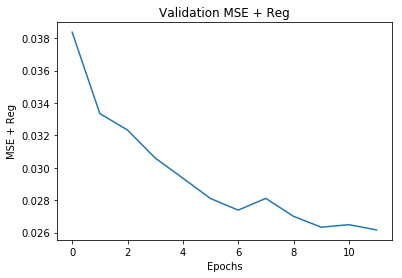

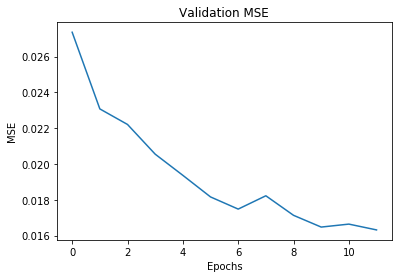

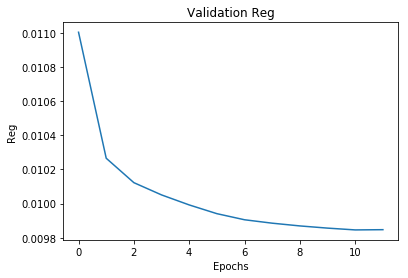

In [8]:
from dpp_nets.helper.plotting import plot_floats

# Training Plots
plot_floats(model['val_loss'], xlabel='Epochs', ylabel='MSE + Reg', title='Validation MSE + Reg')
plot_floats(model['val_pred_loss'], xlabel='Epochs', ylabel='MSE', title='Validation MSE')
plot_floats(model['val_reg_loss'], xlabel='Epochs', ylabel='Reg', title='Validation Reg')

In [9]:
# Evaluation on Test Set

loss, pred_loss, reg_loss = evalset.computeLoss(trainer, model['mode'])
print(str.join(" | ", ['Test Set:', 'Loss: %.5f' % (loss), 
                              'Pred Loss: %.5f' % (pred_loss), 'Reg Loss: %.5f' % (reg_loss)]))

prec, extract = evalset.evaluatePrecision(trainer,model['mode'])
print(str.join(" | ", ['Test Set:', 'Precision: %.5f' % (prec), 'Extract: %.5f' % (extract)]))

Test Set: | Loss: 0.02313 | Pred Loss: 0.01287 | Reg Loss: 0.01026
Test Set: | Precision: 0.58551 | Extract: 0.39390


In [10]:
# Random Samples
evalset.sample(trainer, model['mode'],397)

index is: 397
('poured', 'clear', 'dark', 'orangy', 'gold', 'minimal', 'head') {'0'} [('It', 'poured', 'A', 'clear', 'dark', 'orangy', 'gold', 'with', 'a', 'minimal', 'head', '.')]
('initial', 'aroma', 'sharp', 'spices', 'maple', 'malts') {'1'} [('The', 'initial', 'aroma', 'was', 'of', 'sharp', 'spices', 'and', 'maple', 'malts', '.')]
('alcohol', 'evident', 'taste', 'expected', 'think', "'s", 'potent', 'reported') set() [('The', 'alcohol', 'is', 'more', 'evident', 'in', 'the', 'taste', 'than', 'I', 'expected', 'for', 'a', '7%', 'brew', ';', 'I', 'think', 'it', "'s", 'more', 'potent', 'than', 'reported', '.')]
Precision is: 0.6666666666666666
Extraction Percentage is: 0.3404255319148936
[(I took a gamble on a case of this HSA (as a 2002-2003 the store had it in the discounted out-of-date section)., set()), (It poured A clear dark orangy gold with a minimal head., {'0'}), (The initial aroma was of sharp spices and maple malts., {'1'}), (There's also a touch bitter of hops back there some

In [ ]:
# Random Marginals
evalset.computeMarginals(trainer, model['mode'],397)

index is: 397
0 0.791867884359 ('poured', 'clear', 'dark', 'orangy', 'gold', 'minimal', 'head')
1 0.507210745848 ('initial', 'aroma', 'sharp', 'spices', 'maple', 'malts')
2 0.496880229247 ('took', 'gamble', 'case', '2002', '2003', 'store', 'discounted', 'date', 'section')
3 0.407791350696 ('alcohol', 'evident', 'taste', 'expected', 'think', "'s", 'potent', 'reported')
4 0.320757309149 ('mouthfeel', 'luscious', '--', 'medium', 'thickness', 'offset', 'modest', 'carbonation')
5 0.26473609032 ("'s", 'also', 'touch', 'bitter', 'hops', 'back', 'somewhere', 'well')
6 0.209776629641 ('taste', 'reasonably', 'well', 'balanced', 'syrupy', 'cherry', 'pear', 'sweetness', 'start', 'fades', 'quickly', 'hops', 'kick', 'finish', 'rather', 'tart')


In [ ]:
evalset.computeMAPPredLoss(trainer, model['mode'])

In [ ]:
[*range(3)]